In [1]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
dataframe = pd.read_csv("SP500DATA.csv")
print(dataframe)# Text file data converted to integer data type

           Date    Price     Open     High      Low Vol.  Change %
0    01/12/2021  4766.18  4623.80  4808.52  4494.20    -    0.0436
1    01/11/2021  4567.00  4616.47  4743.74  4560.26    -   -0.0083
2    01/10/2021  4605.38  4324.71  4608.70  4278.70    -    0.0691
3    01/09/2021  4307.54  4531.04  4544.58  4304.90    -   -0.0476
4    01/08/2021  4522.68  4415.90  4537.80  4369.20    -    0.0290
..          ...      ...      ...      ...      ...  ...       ...
618  01/06/1970    72.72    76.55    79.96    72.25    -   -0.0500
619  01/05/1970    76.55    81.52    82.32    68.61    -   -0.0610
620  01/04/1970    81.52    89.63    90.70    79.31    -   -0.0905
621  01/03/1970    89.63    89.50    91.07    86.19    -    0.0015
622  01/02/1970    89.50    85.02    90.33    84.64    -    0.0527

[623 rows x 7 columns]


In [2]:
trainData = dataframe[["Price", "Open"]].to_numpy(dtype = 'float')
targetData = dataframe[["Price"]].to_numpy(dtype = 'float')
date = dataframe[["Date"]].to_numpy(dtype = "str")

norm = MinMaxScaler(feature_range = (0, 1))
trainData = norm.fit_transform(trainData)
targetData = norm.fit_transform(targetData)
trainData = np.flip(trainData)
targetData = np.flip(targetData)
date = np.flip(date)

dateAxis = []
for i in range(date.shape[0]):
    dateAxis.append(float(np.squeeze(date)[i][6:10]) + float(np.squeeze(date)[i][3:5])/12.0)

In [3]:
X = []
Y = []
for i in range(trainData.shape[0] - 5 - 4):
    X.append(trainData[i:i+6])
    Y.append(targetData[i+6:i+6+4])
X = np.array(X)
Y = np.array(Y)
Y = np.swapaxes(Y, 1, 2)

In [4]:
X_fullTraining = []
X_training = []
X_validation = []
X_test = []
Y_fullTraining = []
Y_training = []
Y_validation = []
Y_test = []

X_fullTraining, X_test, Y_fullTraining, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)
X_training, X_validation, Y_training, Y_validation = train_test_split(X_fullTraining, Y_fullTraining, test_size=0.3, shuffle=False)


In [5]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   

        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        hidden = self.init_hidden(batch_size)

        out, hidden = self.rnn(x, hidden)
    
        out = self.fc(out)
    
        return out[:, -1, :], hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [6]:
RNN = Model(input_size=2, output_size=4, hidden_dim=16, n_layers=1)
optimizer = torch.optim.Adam(RNN.parameters(), lr=0.01)
criterion = nn.MSELoss()
RNN

Model(
  (rnn): RNN(2, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=4, bias=True)
)

In [7]:
xTensor = torch.from_numpy(X_training).float()
yTensor = torch.Tensor(Y_training).float()

for epoch in range(100):
    optimizer.zero_grad()
    
    output, hidden = RNN(xTensor)
    loss = criterion(output.reshape(-1), yTensor.view(-1))
    loss.backward()
    
    optimizer.step()
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, 100), end=' ')
        print("Loss:", loss.item())

Epoch: 0/100............. Loss: 0.045836154371500015
Epoch: 10/100............. Loss: 0.0015354609349742532
Epoch: 20/100............. Loss: 0.00070618384052068
Epoch: 30/100............. Loss: 0.000610329385381192
Epoch: 40/100............. Loss: 0.0004421438788995147
Epoch: 50/100............. Loss: 0.00026512850308790803
Epoch: 60/100............. Loss: 0.00010293307423125952
Epoch: 70/100............. Loss: 5.100206908537075e-05
Epoch: 80/100............. Loss: 3.010262480529491e-05
Epoch: 90/100............. Loss: 1.802496444724966e-05


In [8]:
def prediction_error(pred, actual):
    return abs(pred - actual)/pred

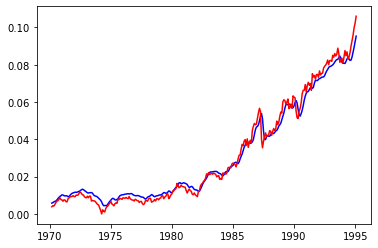

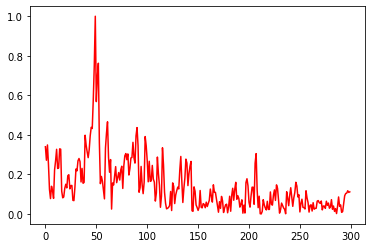

In [9]:
plt.plot(dateAxis[0:300], output.detach().numpy()[:, 0], color = 'blue')
plt.plot( dateAxis[0:300], np.squeeze(Y_training[:, :, 0]), color = 'red')
plt.show()

error = prediction_error(output.detach().numpy()[:, 0], np.squeeze(Y_training[:, :, 0]))
plt.plot(error, color = 'red')
plt.show()

In [10]:
# print("NOISY")
# stdev = [0,0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05,0.1]
# def NormalizeData(data):
#     return (data - np.min(data)) / (np.max(data) - np.min(data))
# def NoiseData(dataset, sigma):
#     dataset_noise = np.ndarray(shape=dataset.shape, dtype=np.float32)
#     #set seed for random numbers
#     random.seed(1)
#     print(np.shape(dataset))
#     for i in range(len(dataset)):
#         s = np.random.normal(0, sigma, 18)
#         index = random.sample(list(range(623)), 18)
#         dataset_noise[i] = dataset[i]    
#         dataset_noise[i, index, 0] = dataset_noise[i, index, 0] + s
#     return dataset_noise

In [11]:
print("NOISY")
stdev = [0,0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05,0.1]
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
def NoiseData(dataset, sigma):
    dataset_noise = np.ndarray(shape=dataset.shape, dtype=np.float32)
    #set seed for random numbers
    random.seed(1)
    for i in range(6):
        s = np.random.normal(0, sigma, 18)
        index = random.sample(list(range(623)), 18)
        dataset_noise[i] = dataset[i]
        dataset_noise[index, i, 0] = dataset_noise[index, i, 0] + s
    return dataset_noise

NOISY


In [12]:
#predict next day (idx = 0)
idx = 0
out_temp = np.concatenate( (Y_test[:, :, idx], Y_test[:, :, idx], Y_test[:, :, idx]), axis = 1)
target_test = norm.inverse_transform(out_temp)[:, [0]]
error_res_all = []
for sigma in stdev:
    print(sigma)
    dataset_test_noise = NoiseData(X_test, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = RNN(test_inputs)
    out_temp = np.concatenate((output_test.detach().numpy()[:, [idx]], 
                               output_test.detach().numpy()[:, [idx]],  
                               output_test.detach().numpy()[:, [idx]]), axis=1)
    predicted_price_test = norm.inverse_transform(out_temp)[:, [0]]
    error = prediction_error(target_test, predicted_price_test)
    error_res_all.append(error.reshape(-1))


0


IndexError: index 582 is out of bounds for axis 0 with size 185

In [ ]:
labels = date[:,0]
error_df=pd.DataFrame(error_res_all, columns=labels, index=stdev).T
error_df